#  Age prediction in Paulsen et al., 2022 human neural organoids with ASD mutations
><b> This notebook contains R code to predict developmental stage in cells from Paulsen et al., 2022, a human neural organoid dataset with ASD mutations.<br> Part 2 uses the pre-trained celltype agnostic model to predict developmental age of mutant and wildtype organoid cells from the transcriptome </b>
<br> <br>First download Paulsen et al 2022 dataset from  https://www.synapse.org/Synapse:syn26346581 and run Paulsen_preprocessing.r

## <i> Part 1. Load preprocessed data and get metadata

In [1]:
setwd("/home/sridevi/inkwell03_sridevi//metadevorganoid/werneranalysis/DevTime_gitub_repo/") #change to the working directory

In [2]:
library(Seurat)
library(caret)
library(dplyr)
library(Matrix)
library(readr)
library(ggplot2)
library(stringr)
library(ggpubr)
library(tidyr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [3]:
final_common_genes<-readRDS("models/commongenes.rds")#list of common genes

In [5]:
# Load preprocessed data obtained using the R script Paulsen_preprocessing.r

In [4]:
load("processed_data/Paulsen2022_processed.Rdata")
load("processed_data/Paulsen2022_metadata.Rdata")

In [5]:
#obtain metadata for each cell type per sample
rep_times <- lapply(Paulsen_pb_celltypes,ncol)  # e.g., replicate the first row 3 times, the second row 2 times
# Replicate rows based on specified times
metadata_full <- metadata[rep(1:nrow(metadata), times = rep_times), ]
dim(metadata_full)

[1] 958   4

In [7]:
#get the lognormalized counts
merged_paulsen_normalized<-lapply(Paulsen_pb_celltypes,function(x){
    data<-GetAssayData(x,layer="data")
   })%>%do.call(cbind,.)

In [8]:
#get additional metadata from the colnames
temp=colnames(merged_paulsen_normalized)%>%str_split(.,"_") #gives the annotations; age and other annotations come from the file name

celltypeinfo<- do.call(rbind, lapply(temp, function(x) { length(x) <- 3; return(x) }))
celltypeinfo <- as.data.frame(celltypeinfo, stringsAsFactors = FALSE)

# Assign column names
colnames(celltypeinfo) <- c("organoid", "celltype", "mutant_wt")
celltypeinfo

organoid,celltype,mutant_wt
<chr>,<chr>,<chr>
g1,aRG,wt
g1,Cajal-Retzius,wt
g1,Cortical Hem,wt
g1,Cycling Progenitors,wt
g1,GABAergic Neurons 1,wt
g1,IPCs,wt
g1,Newborn DL PNs,wt
g1,Newborn PNs,wt
g1,Subcortical,wt


In [9]:
metadata_final<-cbind(metadata_full,celltypeinfo)
head(metadata_final)

,gene,line,age,replicate,organoid,celltype,mutant_wt
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ARID1B,Mito210,1m,r1,g1,aRG,wt
1.1,ARID1B,Mito210,1m,r1,g1,Cajal-Retzius,wt
1.2,ARID1B,Mito210,1m,r1,g1,Cortical Hem,wt
1.3,ARID1B,Mito210,1m,r1,g1,Cycling Progenitors,wt
1.4,ARID1B,Mito210,1m,r1,g1,GABAergic Neurons 1,wt
1.5,ARID1B,Mito210,1m,r1,g1,IPCs,wt


In [10]:
metadata_final$age_months<-parse_number(metadata_final$age)
metadata_final$age_months[metadata_final$age_months>6]<-metadata_final$age_months[metadata_final$age_months>6]/30
table(metadata_final$age_months)


0.933333333333333                 1  1.16666666666667                 3 
               60               290                52               494 
                6 
               62 

In [11]:
metadata_final$age_mut<-paste0(round(metadata_final$age_months,2),"_",metadata_final$mutant_wt)
metadata_final$line_age<-paste0(metadata_final$line,"_",round(metadata_final$age_months,2))

---

## <i>Part 2. Predict age in organoid cell types using celltype agnostic model 

In [12]:
celltypeagnosticmodel<-readRDS("models/original_celltypeagnostic_model.rds")

#check model coefficients
coefs<-as.data.frame(coef(celltypeagnosticmodel$finalModel, celltypeagnosticmodel$finalModel$lambdaOpt))%>%dplyr::filter(s1!=0)
coefs$genes<-rownames(coefs)
coefs

,s1,genes
,<dbl>,<chr>
(Intercept),11.25612595,(Intercept)
PDK4,0.40616305,PDK4
TAC1,-0.06138818,TAC1
CX3CL1,2.02815101,CX3CL1
PNPLA4,-0.96997077,PNPLA4
CACNA2D2,-1.85735642,CACNA2D2
CAMK1G,0.44071996,CAMK1G
NFIX,0.15785721,NFIX
CD9,0.06357692,CD9


In [13]:
#Use pretrained model to predict the ages of the organoid cell types in weeks
metadata_final$predicted_ages_Paulsen<-predict(celltypeagnosticmodel,t(merged_paulsen_normalized[final_common_genes,]))


In [14]:
split_predictions<-split(metadata_final,metadata_final$gene)

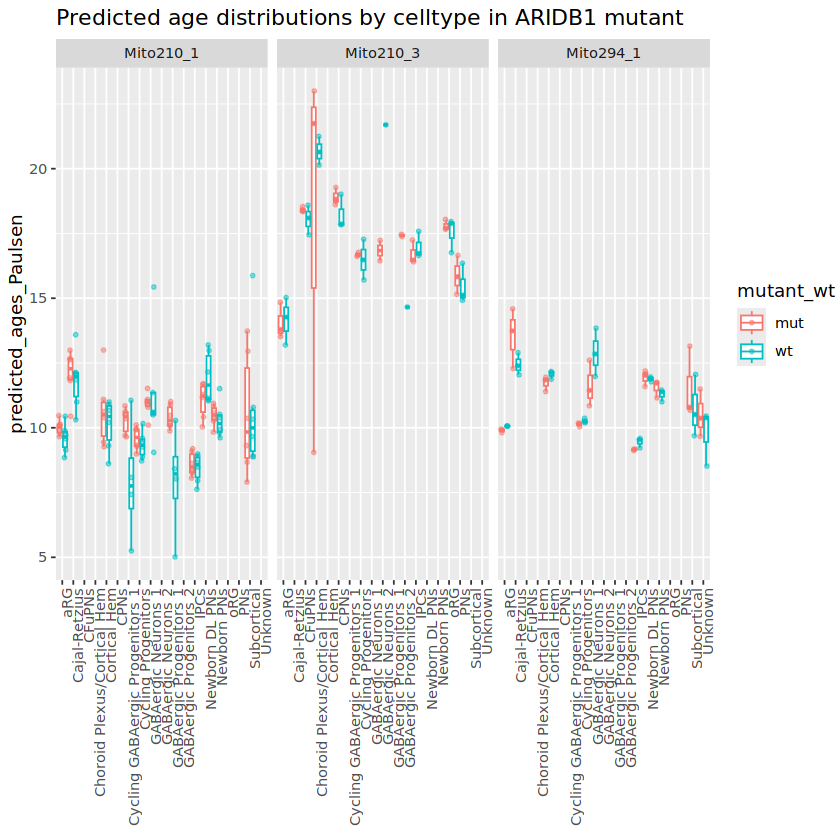

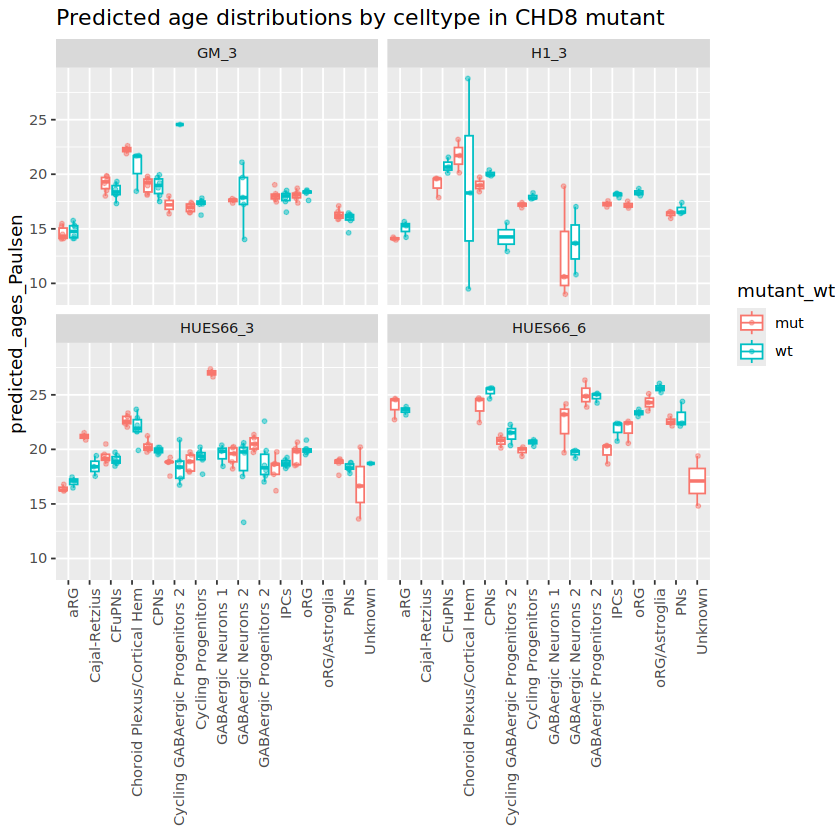

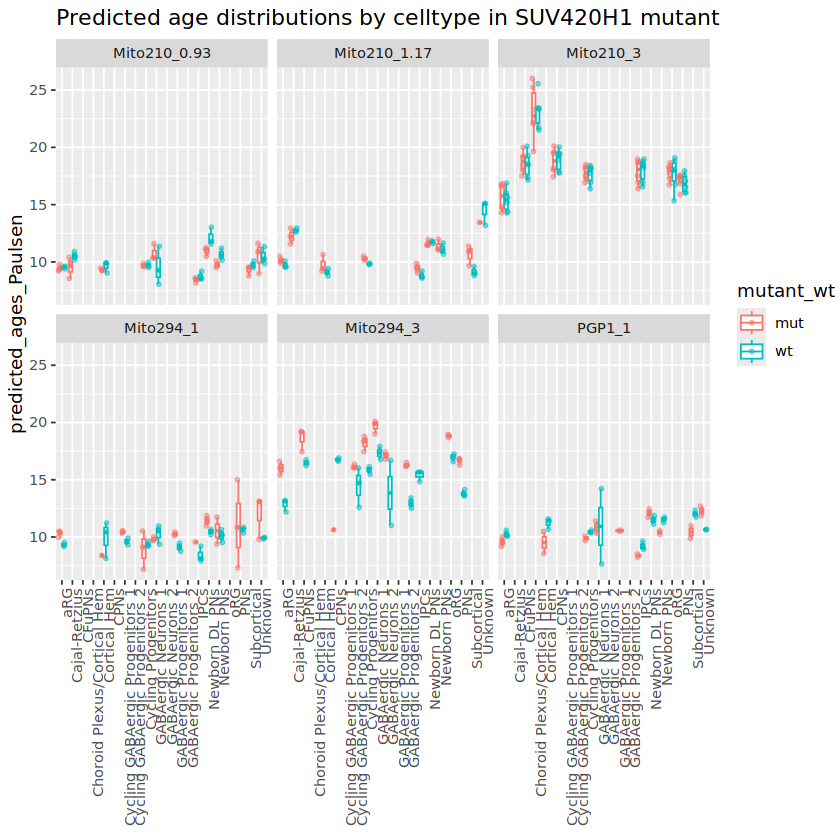

In [15]:
ggplot(split_predictions$ARID1B,aes(y=predicted_ages_Paulsen,col=mutant_wt,x=celltype))+geom_boxplot(outlier.shape = NA,position = position_dodge(width = 1))+
geom_point(size=1,alpha=0.5,aes(col=mutant_wt),position = position_jitterdodge(jitter.width = 0.15, dodge.width = 1))+facet_wrap(~line_age)+xlab("")+
ggtitle("Predicted age distributions by celltype in ARIDB1 mutant")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(split_predictions$CHD8,aes(y=predicted_ages_Paulsen,x=celltype,col=mutant_wt))+geom_boxplot(outlier.shape = NA,position = position_dodge(width = 1))+
geom_point(size=1,alpha=0.5,aes(col=mutant_wt),position = position_jitterdodge(jitter.width = 0.15, dodge.width = 1))+facet_wrap(~line_age)+xlab("")+
ggtitle("Predicted age distributions by celltype in CHD8 mutant")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggplot(split_predictions$SUV420H1,aes(y=predicted_ages_Paulsen,x=celltype,col=mutant_wt))+geom_boxplot(outlier.shape = NA)+
geom_point(size=1,alpha=0.5,aes(col=mutant_wt),position = position_jitterdodge(jitter.width = 0.15, dodge.width = 1))+facet_wrap(~line_age)+xlab("")+
ggtitle("Predicted age distributions by celltype in SUV420H1 mutant")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [16]:
datatoplot_gabaergicprog<-metadata_final%>%filter(str_detect(celltype,"GABAergic Progenitors") ==TRUE)

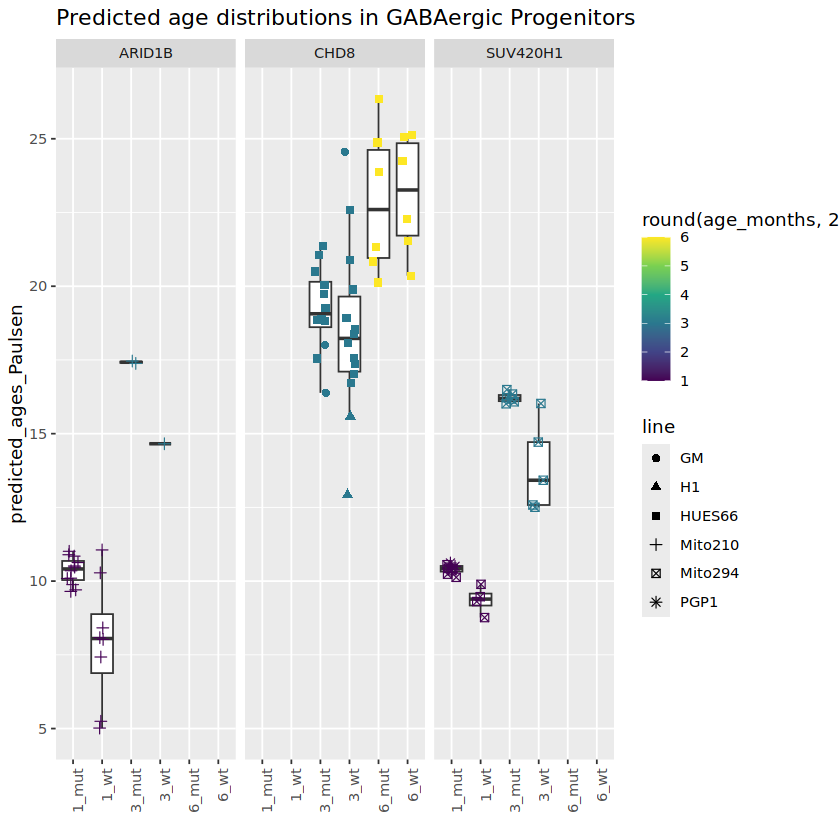

In [17]:
gabaprog_plt_paulsen<- ggplot(datatoplot_gabaergicprog,aes(y=predicted_ages_Paulsen,x=age_mut))+
geom_boxplot(outlier.shape = NA,position = position_dodge(width = 1))+
geom_jitter(size=2,aes(col=round(age_months,2),shape=line),width=0.2)+scale_color_viridis_c()+
facet_wrap(~gene)+xlab("")+
ggtitle("Predicted age distributions in GABAergic Progenitors")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

gabaprog_plt_paulsen

In [19]:
png(file="figures/Paulsen2022_predictions.png")
gabaprog_plt_paulsen
dev.off()

pdf 
  2

In [18]:
result<-datatoplot_gabaergicprog%>%group_by(gene,age)%>%summarise(
    p_value = ifelse(
      length(unique(mutant_wt)) == 2,
      wilcox.test(predicted_ages_Paulsen ~ mutant_wt)$p.value,
      NA
    ),
    .groups = "drop"
  )
result$adj_p<-p.adjust(result$p_value,method='fdr')
result

gene,age,p_value,adj_p
<chr>,<chr>,<dbl>,<dbl>
ARID1B,1m,0.015860919,0.03172184
ARID1B,3m,0.666666667,0.69913420
CHD8,3m,0.273980969,0.41097145
CHD8,6m,0.699134199,0.69913420
SUV420H1,1m,0.004040404,0.02424242
SUV420H1,3m,0.008658009,0.02597403
